In [1]:
import sys
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = [8,8]
#sns.set_style("whitegrid")

## Data Import
The open source car dataset from Standford is used in this notebook (source: https://ai.stanford.edu/~jkrause/cars/car_dataset.html).

In [2]:
import scipy.io as sio
matfile = sio.loadmat(r"data\cars_annos.mat")

In [3]:
# get the keys of this dictionary
matfile.keys()

dict_keys(['__header__', '__version__', '__globals__', 'annotations', 'class_names'])

In [4]:
matfile['annotations'][0]

array([(array(['car_ims/000001.jpg'], dtype='<U18'), array([[112]], dtype=uint8), array([[7]], dtype=uint8), array([[853]], dtype=uint16), array([[717]], dtype=uint16), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
       (array(['car_ims/000002.jpg'], dtype='<U18'), array([[48]], dtype=uint8), array([[24]], dtype=uint8), array([[441]], dtype=uint16), array([[202]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
       (array(['car_ims/000003.jpg'], dtype='<U18'), array([[7]], dtype=uint8), array([[4]], dtype=uint8), array([[277]], dtype=uint16), array([[180]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
       ...,
       (array(['car_ims/016183.jpg'], dtype='<U18'), array([[25]], dtype=uint8), array([[32]], dtype=uint8), array([[587]], dtype=uint16), array([[359]], dtype=uint16), array([[196]], dtype=uint8), array([[1]], dtype=uint8)),
       (array(['car_ims/016184.jpg'], dtype='<U18'), array([[56]], dtype=uint8), array([[60]],

In [5]:
data = [[row.flat[0] for row in line] for line in matfile['annotations'][0]]

columns = ["filename", "bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2", "class", "test"]

df = pd.DataFrame(data, columns=columns)

In [6]:
df.head()

,filename,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,test
0,car_ims/000001.jpg,112,7,853,717,1,0
1,car_ims/000002.jpg,48,24,441,202,1,0
2,car_ims/000003.jpg,7,4,277,180,1,0
3,car_ims/000004.jpg,33,50,197,150,1,0
4,car_ims/000005.jpg,5,8,83,58,1,0


In [7]:
# drop the bounding box information, because we are only applying normal image classification
df = df.drop(columns=["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2"])

In [8]:
df.head()

,filename,class,test
0,car_ims/000001.jpg,1,0
1,car_ims/000002.jpg,1,0
2,car_ims/000003.jpg,1,0
3,car_ims/000004.jpg,1,0
4,car_ims/000005.jpg,1,0


In [9]:
# remove the folder car_ims from the filenames to only have the filename
df["filename"] = df["filename"].apply(lambda x: x.replace("car_ims/", ""))
df.head()

,filename,class,test
0,000001.jpg,1,0
1,000002.jpg,1,0
2,000003.jpg,1,0
3,000004.jpg,1,0
4,000005.jpg,1,0


In [10]:
# check unique values and get number of classes
for column in df.columns:
    print(f"Column {column} contains {df[column].unique().shape[0]} unique values. { 100 * df[column].unique().shape[0] / df[column].shape[0]}% of total data. \n")

Column filename contains 16185 unique values. 100.0% of total data. 

Column class contains 196 unique values. 1.2109978375038617% of total data. 

Column test contains 2 unique values. 0.01235712079085573% of total data. 



There are in total 196 different classes available. Let's now check how many of the images are used for testing.

In [11]:
num_images = df.shape[0]
num_test = np.sum(df["test"] == 1)
print(f"There are {num_images} images in this dataset.")
print(f"{num_test} of these images are in the test set ({100 * num_test / num_images}% of total data).")

There are 16185 images in this dataset.
8041 of these images are in the test set (49.68180413963547% of total data).


In [12]:
# get the class names
class_names = [[row.flat[0] for row in line] for line in matfile['class_names'][0]]

In [13]:
class_names = [class_names[idx][0] for idx in range(len(class_names))]

## EDA

Let's first check the shape of the images. For this, let's load some images into numpy arrays and check the shapes. For this, I only want to check the shapes of the first images in order to check whether they are of equal size or not. If not, then different images sizes are to be tested for the final model and the best performing shall be used in the end.

In [14]:
from PIL import Image

def files_to_numpy(df, folder):
    list_of_files = df["filename"][:20].to_list()
    
    # read data into numpy array
    for img_file in list_of_files:
        image = np.array(Image.open(os.path.join(folder, img_file) ))
        print(image.shape)

In [15]:
files_to_numpy(df, r"data\car_ims")

(768, 1024, 3)
(219, 460, 3)
(233, 310, 3)
(188, 250, 3)
(64, 85, 3)
(111, 250, 3)
(176, 464, 3)
(85, 113, 3)
(276, 300, 3)
(111, 148, 3)
(72, 96, 3)
(100, 160, 3)
(179, 300, 3)
(120, 160, 3)
(71, 94, 3)
(93, 124, 3)
(91, 160, 3)
(525, 700, 3)
(272, 450, 3)
(439, 700, 3)


Okay. Seems like there are a lot of different images sizes available. Let's later check different images sizes and train models on them in order to find the best suited. In addition, let's convert the images into grayscale images later, because this should be sufficient for a cars classifier. <br> <br>
Let's now take a look into some images.

In [16]:
def show_image(df, folder, index, classes=class_names):
    filename = os.path.join(folder, df["filename"][index])
    class_name = classes[df["class"][index]]
    
    image = plt.imread(filename)
    plt.title(class_name)
    plt.imshow(image)

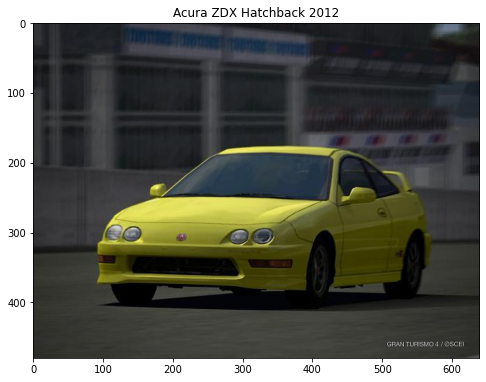

In [17]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

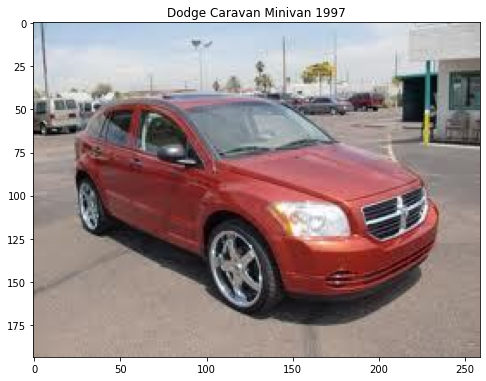

In [18]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

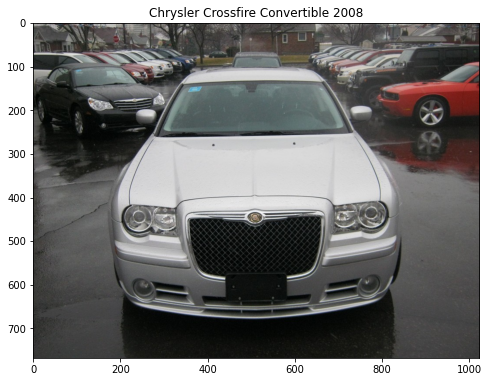

In [19]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

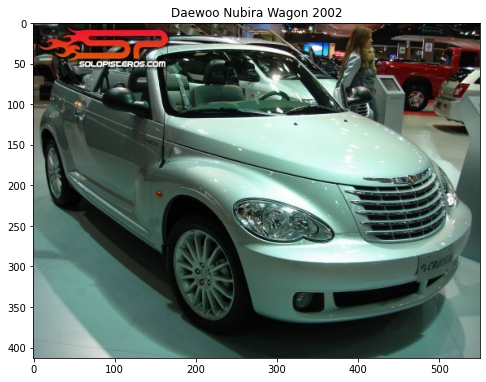

In [20]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

### Check distribution of data
Let's now check the data distribution. This is to check if there are enough images for each class and to maybe apply some data imbalance strategies for balancing the dataset.

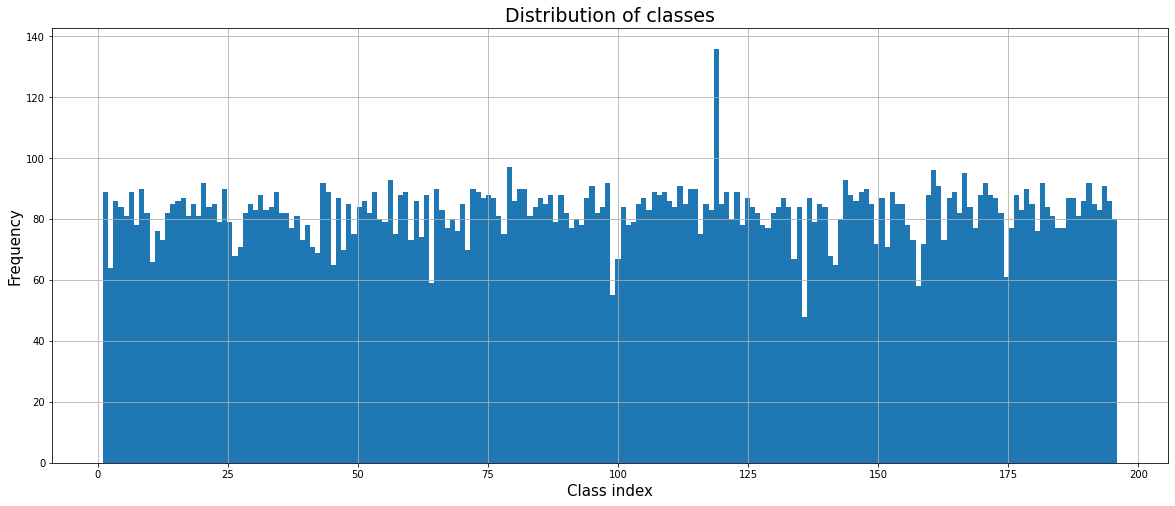

In [21]:
plt.figure(figsize=(20, 8))
df["class"].hist(bins=len(class_names))
plt.title("Distribution of classes", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

The dataset looks quite balanced. However, some classes seem to have less samples than others, which could result in a worse performance of the model on these classes. Let's later check if balancing can improve the overal performance! <br> <br>
Let's now check the distributions for the training and test set. This is important to ensure that the test set contains a similar distribution than the training set. For this dataset, almost the half of all images are in the test set. I think this is done in order to ensure that there are enough images of all classes in the test set. 

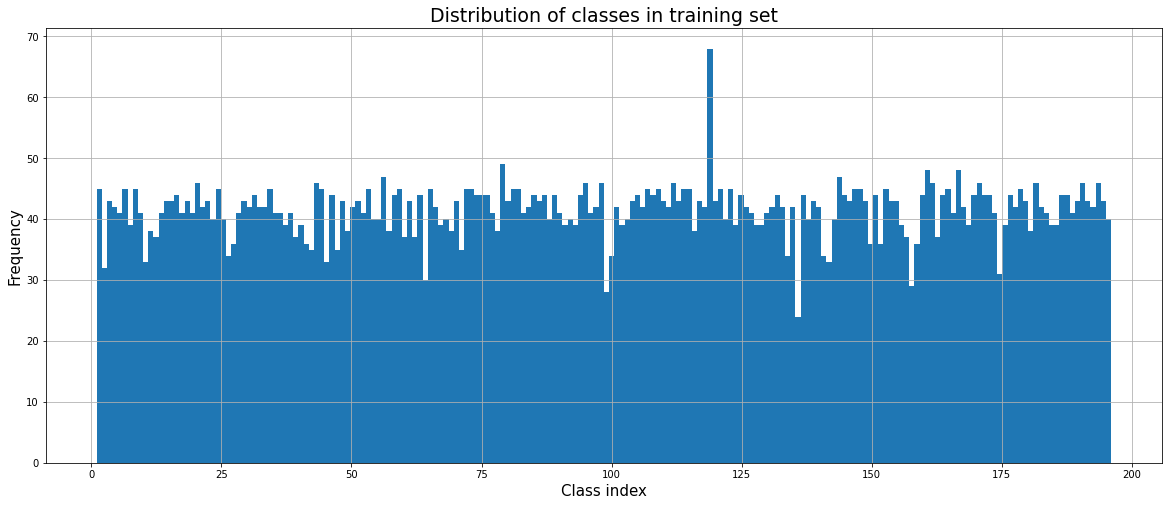

In [22]:
# check distribution of training set
plt.figure(figsize=(20, 8))
df.loc[df["test"] == 0]["class"].hist(bins=len(class_names))
plt.title("Distribution of classes in training set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

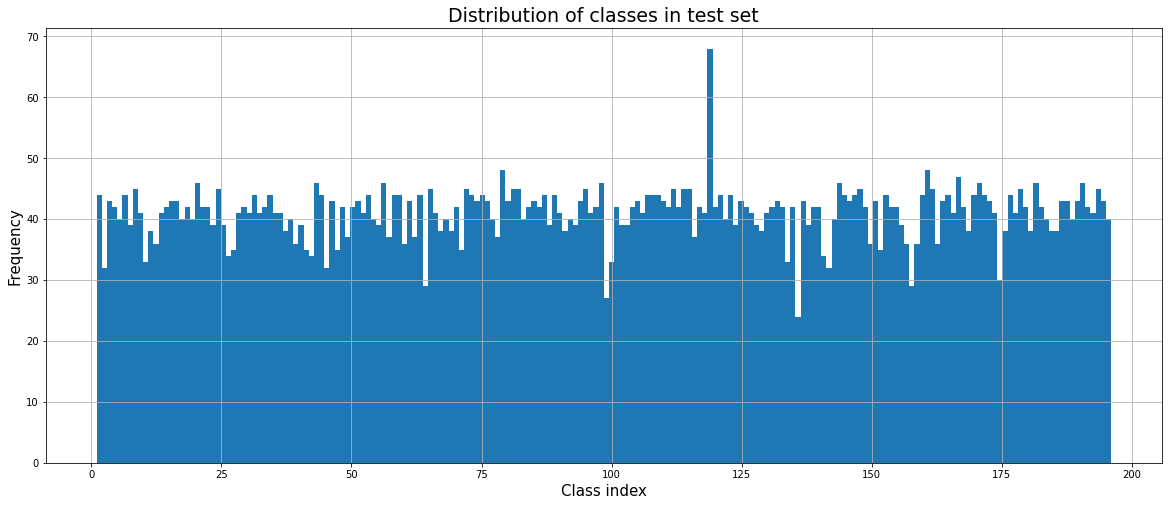

In [23]:
# check distribution of training set
plt.figure(figsize=(20, 8))
df.loc[df["test"] == 1]["class"].hist(bins=len(class_names))
plt.title("Distribution of classes in test set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

As one can see, the distributions are almost the same! This is perfect, because the test set therefore represents the real distribution and we can better test the performance of the final model! <br> <br>
Let's now create a training and a validation set and let's check the distributions there.

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

df_training = df.loc[df["test"] == 0]
df_test = df.loc[df["test"] == 1]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(df_training.drop(columns="class"), df_training["class"]):
    print("TRAIN:", train_index, "TEST:", test_index)
    df_train = df_training.iloc[train_index]
    df_val = df_training.iloc[test_index]

TRAIN: [5009  419 7327 ... 2137 5950 1161] TEST: [ 160 6076 2156 ... 4412 5628 4225]


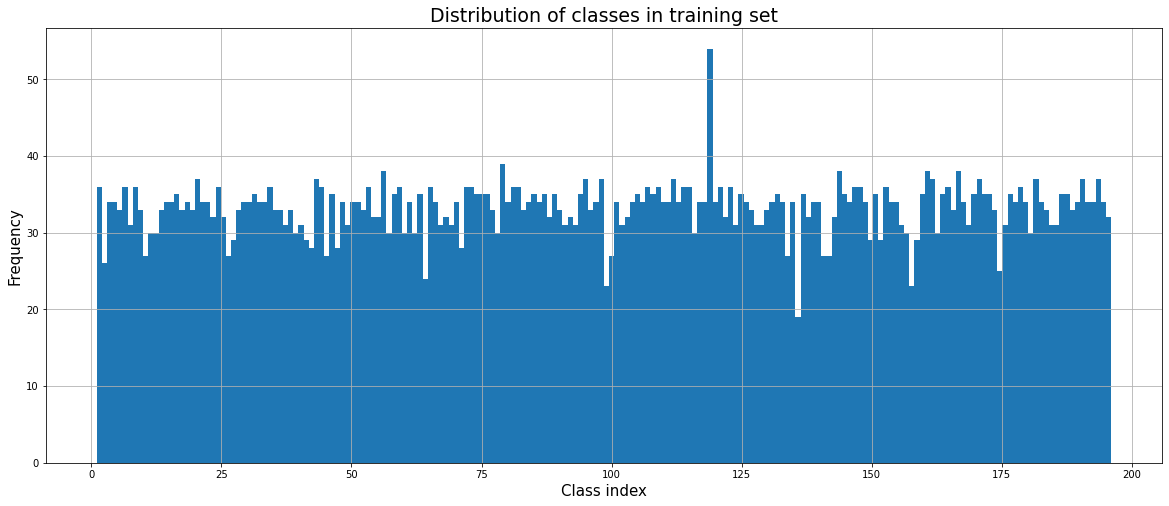

In [25]:
# check distribution of training set
plt.figure(figsize=(20, 8))
df_train["class"].hist(bins=len(class_names))
plt.title("Distribution of classes in training set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

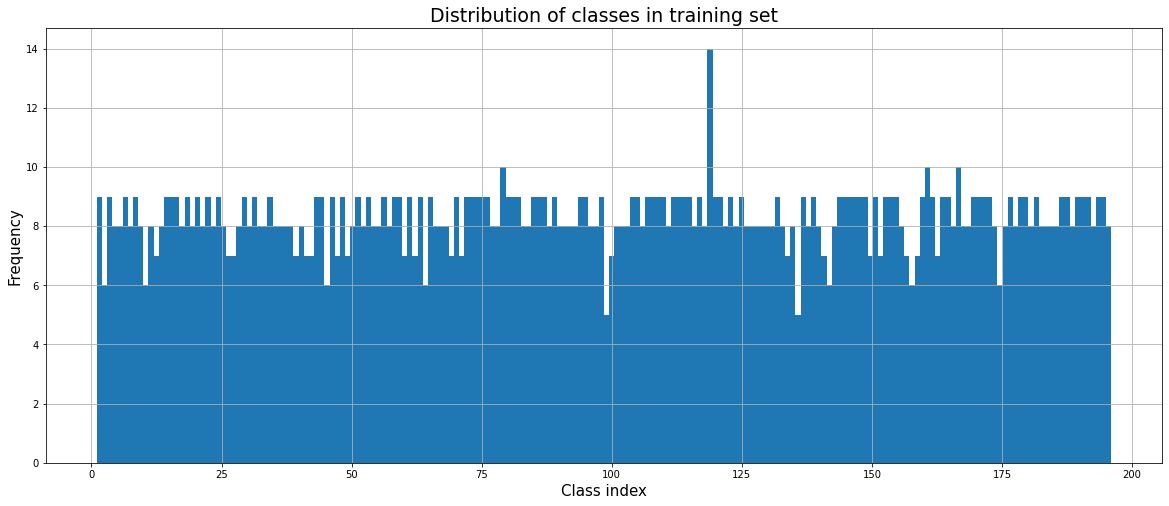

In [26]:
# check distribution of training set
plt.figure(figsize=(20, 8))
df_val["class"].hist(bins=len(class_names))
plt.title("Distribution of classes in training set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

## Create Tensorflow Input Pipeline

In [27]:
import imgaug.augmenters as iaa

def apply_augmentations(input_image):
    input_image = np.expand_dims(input_image, axis=0)
    aug_list = [
                iaa.Rot90((1, 3)),
                iaa.Fliplr(1.0),
                iaa.Flipud(1.0)
               ]
    for idx, aug in enumerate(aug_list):
        # only apply augmentation in 40% of the cases -> in total: ~ 20% of images not augmented (0.6**3)
        # P_single_aug = 1 - exp((1/N) * ln(P_not_aug))
        random_nr = np.random.rand()
        input_image = np.clip(aug(images=input_image), 0., 255.) if random_nr <= 0.4 else input_image
    
    return np.squeeze(input_image, axis=0)

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen_train = ImageDataGenerator(rescale=1./255, preprocessing_function=apply_augmentations)
datagen_val = ImageDataGenerator(rescale = 1. / 255)

In [29]:
# create datagenerators by calling flow_from_dataframe on them
path_to_images = r"data\car_ims"
batch_size = 8
shuffle = True
target_size = (128, 128)

train_generator = datagen_train.flow_from_dataframe(dataframe=df_train, directory=path_to_images,
                                                    x_col="filename", y_col="class", 
                                                    batch_size=batch_size, shuffle=shuffle,
                                                    class_mode="raw", target_size=target_size, 
                                                    color_mode="rgb", seed=42)

valid_generator = datagen_val.flow_from_dataframe(dataframe=df_val, directory=path_to_images,
                                                    x_col="filename", y_col="class", 
                                                    batch_size=batch_size, shuffle=shuffle,
                                                    class_mode="raw", target_size=target_size, 
                                                    color_mode="rgb", seed=42)

steps_per_epoch_train = train_generator.__len__()
steps_per_epoch_val = valid_generator.__len__()

Found 6515 validated image filenames.
Found 1629 validated image filenames.


Let's now build a keras model factory to try out different cnns and use the best performing by considering the trade off between performance and complexity.

In [34]:
class KerasModelFactory():
    '''
    This class can be used to create a keras model and return it.
    '''
    
    def __init__(self):
        '''
        Constructor...
        '''
        pass
    
    def create_and_return_keras_model(self, model_name, num_classes, input_shape, 
                                      activation_func="softmax", transfer_learning=False):
        '''
        This function takes some information about the keras model to create and returns it. The model_name must be one
        of the following: ["efficientnetb0", "xception", "densenet121", "resnet18", "resnet34"]
        
        Args:
            model_name (str): Name of the keras model which shall be instantiated.
            num_classes (int): The number of classes and therefore the number of output neurons.
            input_shape (tuple): Shape of input images (height, widht, depth)
            activation_func (str): Activation function that should be used on the output layer
            transfer_learning (bool): Whether to reuse the trained weights on the imagenet dataset 
                                         or to use newly initialized weights
        '''
        if (not isinstance(model_name, str) or 
           model_name not in ["efficientnetb0", "xception", "densenet121", "resnet18", "resnet34"]):
                raise ValueError("Input model_name is invalid! Check if it is of type string and if its in the list of models.")
        
        if not isinstance(num_classes, int):
            raise ValueError("Input num_classes has the wrong datatype!")
        
        if not isinstance(transfer_learning, bool):
            raise ValueError("Input transfer_leraning has the wrong datatype!")
        
        if not isinstance(activation_func, str):
            raise ValueError("Input activation_func has the wrong datatype!")
        
        weights = "imagenet" if transfer_learning else None
        
        if model_name == "efficientnetb0":
            from tensorflow.keras.applications import EfficientNetB0
            model = EfficientNetB0(weights=weights, include_top=False, input_shape=input_shape)
        elif model_name == "xception":
            from tensorflow.keras.applications import Xception
            model = Xception(weights=weights, include_top=False, input_shape=input_shape)
        else:
            from classification_models.keras import Classifiers
            net, _ = Classifiers.get(model_name)
            model = net(input_shape=input_shape, weights=weights, include_top=False)
            
        # add a global spatial average pooling layer
        # this helps to decrease the risk of overfitting and to plot class activation maps
        x = model.output
        x = keras.layers.GlobalAveragePooling2D()(x)

        # and a fully connected output/classification layer
        predictions = keras.layers.Dense(num_classes, activation=activation_func)(x)

        # create the full network so we can train on it
        model = keras.models.Model(inputs=model.input, outputs=predictions)
        
        return model

In [35]:
# test keras factory
factory = KerasModelFactory()

model = factory.create_and_return_keras_model("xception", 
                                              num_classes=len(class_names), 
                                              input_shape=(128, 128, 3),
                                              activation_func="softmax",
                                              transfer_learning=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [21]:
# Next Steps: 
# 1. Check data distribution
# 2. Create tensorflow input pipeline with normalization, conversion to grayscale
# 3. Use small images to find best suited cnn
# 4. Check different images sizes on winning cnn.
# 5. Apply data augmentation.
# 6. Apply Bayesian Hyperparameter Search to find best hyperparameters.
# 7. Plot Class Activation Maps.